# P7-05: Results visualization - QU
- Used to display the prediction results
- Compares predicted masks with actual masks
- Compares the predicted objects with the actual objects 
- Illustration of Images, Masks and Glands

## Set up Google Colab 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/BA_SemanticSegmentation_JonasHeinke/___P7_Eigenes_Projekt_Segmentation_QU/

/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte


In [ ]:
ls

Codeoptimierung_Hinweise.py
___Datasets/
___P3-1_UNET-RESNET_NODE-PL-Segmenation_QU/
___P3_neural-odes-segmentation-master_QU/
___P4-1_UNET-PL_Segmentation_CRAG/
___P4_neural-odes-segmentation-master_CRAG/
___P5_Eigenes_Projekt_Segmentation_CRAG/
___P7_Eigenes_Projekt_Segmentation_QU/


In [ ]:
cd ___P7_Eigenes_Projekt_Segmentation_QU/

/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P7_Eigenes_Projekt_Segmentation_QU


## Libraries, moduls

In [ ]:
# Imports
import pathlib
import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize
import os
import matplotlib.pyplot as plt
from PIL import Image
import pickle # zum speichern
# PL - Pinckaers, Litjens
from  MODULE.PL.metrics import ObjectDice, ObjectHausdorff, F1score
# JS -Schmidt
from MODULE.JS.inference import predict
from MODULE.JS.transformations import normalize_01, re_normalize
from MODULE.JS.unet import UNet
# JH - Jonas Heinke
from configuration_QU import Path   as PATH   # Paths and filenames
from configuration_QU import Inputs as INPUT    # Image parameters
from configuration_QU import CfgModel as CFG_MODEL  # Model parameters
from configuration_QU import EXPERIMENT # Name / key of the experiment    
from MODULE.JH.img_array_transform import ArrayTransform as TRANSFORM
from MODULE.JH.visualize import Show as SHOW

In [ ]:
# For control
VERBOSE=True
# Experiment
print(EXPERIMENT)
# QU_(bl)_blocks5_cout2_optAdam_lr0.001_ep600_h352_w512_ft64

QU_vgl(open8x8_2021-08-25)_blocks5_cout2_optAdam_lr0.001_ep600_h512_w768_ft64


## List of file paths

In [ ]:
path=PATH() # Instance of the class required for method call
# Source paths
path_experiment   = path.results  / EXPERIMENT              #  Ergebnisse des Experiments
if VERBOSE:
    print('Serie: ', path.serie)
    print(path_experiment)
path_inputImages       = path.results  / EXPERIMENT / 'images'
path_actualMasks  = path.results  / EXPERIMENT / 'actualMasks'
path_predictMasks = path.results  / EXPERIMENT / 'predictMasks'
path_predictMasksMorph = path.results  / EXPERIMENT / 'predictMasksMorph'
path_predictObjects= path.results  / EXPERIMENT / 'predictObjects'  # =nachbearbeitete prognostizierte Masken
path_predictContourCodes= path.results  / EXPERIMENT / 'predictContourCodes' #= Kontur der prognostizierten Objekte
#  Paths with filenames
inputImages_filenames  = np.sort(path.get_filenames(path_inputImages  , dateifilter= '*.png'))
actualMasks_filenames  = np.sort(path.get_filenames(path_actualMasks, dateifilter= '*.png'))
predictMasks_filenames = np.sort(path.get_filenames(path_predictMasks, dateifilter= '*.png'))
predictMasksMorph_filenames   = np.sort(path.get_filenames(path_predictMasksMorph, dateifilter= '*.png'))
predictObjects_filenames      = np.sort(path.get_filenames(path_predictObjects, dateifilter= '*.png'))
predictContourCodes_filenames = np.sort(path.get_filenames(path_predictContourCodes , dateifilter= '*.pkl'))
# Number of samples
sample_anzahl=len(inputImages_filenames) # -> für alle gleich

Serie:  A
/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P7_Eigenes_Projekt_Segmentation_QU/results/QU_vgl(open8x8_2021-08-25)_blocks5_cout2_optAdam_lr0.001_ep600_h512_w768_ft64


In [ ]:
print(f'Number of image-mask-samples for prediction: {sample_anzahl}\n')
if VERBOSE:
    for idx in range(len(inputImages_filenames)):
        print(idx, ' | ', os.path.basename(inputImages_filenames[idx]),' >',\
                          os.path.basename(actualMasks_filenames[idx]) ,' >',\
                          os.path.basename(predictMasks_filenames[idx]) ,' >',\
                          os.path.basename(predictMasksMorph_filenames[idx]) ,' >',\
                          os.path.basename(predictContourCodes_filenames[idx]))
        

Number of image-mask-samples for prediction: 60

0  |  result_test_00.png  > result_test_00.png  > result_test_00.png  > result_test_00.png  > result_test_00.pkl
1  |  result_test_01.png  > result_test_01.png  > result_test_01.png  > result_test_01.png  > result_test_01.pkl
2  |  result_test_02.png  > result_test_02.png  > result_test_02.png  > result_test_02.png  > result_test_02.pkl
3  |  result_test_03.png  > result_test_03.png  > result_test_03.png  > result_test_03.png  > result_test_03.pkl
4  |  result_test_04.png  > result_test_04.png  > result_test_04.png  > result_test_04.png  > result_test_04.pkl
5  |  result_test_05.png  > result_test_05.png  > result_test_05.png  > result_test_05.png  > result_test_05.pkl
6  |  result_test_06.png  > result_test_06.png  > result_test_06.png  > result_test_06.png  > result_test_06.pkl
7  |  result_test_07.png  > result_test_07.png  > result_test_07.png  > result_test_07.png  > result_test_07.pkl
8  |  result_test_08.png  > result_test_08.png 

## Read in images, masks and contours
- The size of the test images and test masks correspond to those of the training.

In [ ]:
input_images=[]
actual_masks=[]
predict_masks=[]
predict_masks_morph=[]
predict_objects=[]
contourcodes_list=[]

for idx in range(sample_anzahl):
    input_images.append(imread(inputImages_filenames[idx]))
    actual_masks.append(imread(actualMasks_filenames[idx]))
    predict_masks.append(imread(predictMasks_filenames[idx]))
    predict_masks_morph.append(imread(predictMasksMorph_filenames[idx]))
    predict_objects.append(imread(predictObjects_filenames[idx]))
    file=open(predictContourCodes_filenames[idx], 'rb')
    contourcodes_list.append(pickle.load(file))
if VERBOSE:    
    print(input_images[0].shape, actual_masks[0].shape, predict_masks[0].shape, predict_masks_morph[0].shape, predict_objects[0].shape)

(512, 768, 3) (512, 768) (512, 768) (512, 768) (512, 768)


## Evaluation of the test set (MEASURE)

### a) Evaluation of the prediction masks without post-processing

In [ ]:
transform=TRANSFORM()
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
anzahl=0
protokolldatei = open(path_experiment / 'protocol_prediction_class-based.txt','w') #+
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks.shape: {predict_masks[0].shape}\n\n')
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
    try:
        actual_mask= transform.twoClasses(actual_masks[idx])
        predict_mask= predict_masks[idx]
        dice_img = ObjectDice(predict_mask,        actual_mask)
        f1_img = F1score(predict_mask,              actual_mask)
        hausdorff_img = ObjectHausdorff(predict_mask,  actual_mask)
        dice += dice_img
        f1 += f1_img
        hausdorff += hausdorff_img
        print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictMasks_filenames[idx])}')
        print(print_string)
        anzahl +=1
        # --- Protokoll ---
        protokolldatei.write(print_string+'\n')
        #-------------------------------------
    except:
        i_error +=1
        print('Error: ',i_error, 'Zyklus: ', idx)
    else:
        pass


 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.759 |     1.000 |        86.000 | result_test_00.png | result_test_00.png
   1 |     0.894 |     1.000 |        73.790 | result_test_01.png | result_test_01.png
   2 |     0.934 |     1.000 |       271.207 | result_test_02.png | result_test_02.png
   3 |     0.954 |     1.000 |       203.494 | result_test_03.png | result_test_03.png
   4 |     0.893 |     1.000 |        78.230 | result_test_04.png | result_test_04.png
   5 |     0.961 |     1.000 |        52.773 | result_test_05.png | result_test_05.png
   6 |     0.752 |     1.000 |       296.014 | result_test_06.png | result_test_06.png
   7 |     0.934 |     1.000 |        42.450 | result_test_07.png | result_test_07.png
   8 |     0.884 |     1.000 |        51.000 | result_test_08.png | result_test_08.png
   9 |     0.874 |     1.000 |        76.942 | result_test_09.png | result_test_09.png
  10 |     0.803 |     1.000 |       304.810 | 

In [ ]:
print('Prediction, class-based')
print('-- Averages -----------')
print('dice-idx:', dice / anzahl )
print('f1-score:', f1 / anzahl )
print('weighted shape:', hausdorff / anzahl)
print('count io.: ', anzahl)
print('errors: ', i_error)
protokolldatei.write('Prediction, class-based\n')
protokolldatei.write(f'\n Average: dice-idx: {dice / anzahl}, f1-score: {f1 / anzahl}, weighted shape: {hausdorff / anzahl}\n')
protokolldatei.close()

Prediction, class-based
-- Averages -----------
dice-idx: 0.8978732397294489
f1-score: 1.0
weighted shape: 123.12402053824192
count io.:  60
errors:  0


### b) Evaluation of the post-processing prediction masks

In [ ]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
anzahl=0

protokolldatei = open(path_experiment /\
                      'protocol_prediction_with_post-processing_class-base.txt','w') #+
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'input_images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks_morph.shape: {predict_masks[0].shape}\n\n')
# Tabellenkopf
print_string=(f' idx | dice_img  | f1_img    | hausdorff_img | actualMasks        | predict_masks_morph')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
    try:
        actual_mask       = transform.twoClasses(actual_masks[idx])
        predict_mask_morph=predict_masks_morph[idx]
        dice_img = ObjectDice(predict_mask_morph,        actual_mask)
        f1_img = F1score(predict_mask_morph,              actual_mask)
        hausdorff_img = ObjectHausdorff(predict_mask_morph,  actual_mask)
        dice += dice_img
        f1 += f1_img
        hausdorff += hausdorff_img
        print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictMasksMorph_filenames[idx])}')
        print(print_string)
        anzahl +=1
        # --- Protokoll ---
        protokolldatei.write(print_string+'\n')
        #-------------------------------------
    except:
        i_error +=1
        print('Error: ',i_error, 'Cycle: ', idx)

 idx | dice_img  | f1_img    | hausdorff_img | actualMasks        | predict_masks_morph
   0 |     0.744 |     1.000 |        98.087 | result_test_00.png | result_test_00.png
   1 |     0.889 |     1.000 |       119.269 | result_test_01.png | result_test_01.png
   2 |     0.958 |     1.000 |       271.207 | result_test_02.png | result_test_02.png
   3 |     0.955 |     1.000 |       201.604 | result_test_03.png | result_test_03.png
   4 |     0.886 |     1.000 |        60.000 | result_test_04.png | result_test_04.png
   5 |     0.961 |     1.000 |        37.855 | result_test_05.png | result_test_05.png
   6 |     0.754 |     1.000 |       290.303 | result_test_06.png | result_test_06.png
   7 |     0.931 |     1.000 |        42.720 | result_test_07.png | result_test_07.png
   8 |     0.873 |     1.000 |        52.000 | result_test_08.png | result_test_08.png
   9 |     0.875 |     1.000 |        89.320 | result_test_09.png | result_test_09.png
  10 |     0.811 |     1.000 |       299.1

In [ ]:
print('Prediction with post-processing, class-based')
print('-- Averages --------------------------------')
print('dice-idx:', dice / anzahl )
print('f1-score:', f1 / anzahl )
print('weighted shape:', hausdorff / anzahl)
print('count io.: ', anzahl)
print('errors: ', i_error)
protokolldatei.write('Prediction with post-processing, class-based\n')
protokolldatei.write(f'\n Average: dice-idx: {dice / anzahl}, f1-score: {f1 / anzahl}, weighted shape: {hausdorff / anzahl}\n')
protokolldatei.close() 

Prediction with post-processing, class-based
-- Averages --------------------------------
dice-idx: 0.89997178210149
f1-score: 1.0
weighted shape: 111.87236422363145
count io.:  60
errors:  0


### c) Evaluation of the predicted glands (objects)

In [ ]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
anzahl=0
protokolldatei = open(path_experiment /\
                      'protokoll_prediction_with_post-processing_object-based.txt','w')
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks.shape: {predict_objects[0].shape}\n\n')
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
    try:
        actual_mask= actual_masks[idx]
        predict_object= predict_objects[idx]
        dice_img = ObjectDice(predict_object,        actual_mask)
        f1_img = F1score(predict_object,              actual_mask)
        hausdorff_img = ObjectHausdorff(predict_object,  actual_mask)
        dice += dice_img
        f1 += f1_img
        hausdorff += hausdorff_img
        print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictObjects_filenames[idx])}')
        print(print_string)
        anzahl +=1
        # --- Protokoll ---
        protokolldatei.write(print_string+'\n')
        #-------------------------------------
    except:
        i_error +=1
        print('Error: ',i_error, 'Cycle: ', idx)
    else:
        pass        

 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.499 |     0.207 |       274.853 | result_test_00.png | result_test_00.png
   1 |     0.889 |     0.800 |        88.186 | result_test_01.png | result_test_01.png
   2 |     0.958 |     0.500 |        27.427 | result_test_02.png | result_test_02.png
   3 |     0.948 |     0.667 |        17.699 | result_test_03.png | result_test_03.png
   4 |     0.731 |     0.744 |        91.757 | result_test_04.png | result_test_04.png
   5 |     0.961 |     0.923 |        17.752 | result_test_05.png | result_test_05.png
   6 |     0.534 |     0.727 |       234.796 | result_test_06.png | result_test_06.png
   7 |     0.910 |     0.750 |        50.551 | result_test_07.png | result_test_07.png
   8 |     0.669 |     0.625 |       150.235 | result_test_08.png | result_test_08.png
   9 |     0.688 |     0.520 |       110.002 | result_test_09.png | result_test_09.png
  10 |     0.789 |     0.333 |       118.394 | 

In [ ]:
print('Mit Nachbearbeitung, Objektbezogen')
print('--Mittelwerte------------------------------------')
print('ObjectDice:', dice / anzahl )
print('F1:', f1 / anzahl )
print('Hausdorff:', hausdorff / anzahl)
print('Anzahl io.: ', anzahl)
print('Errors: ', i_error)

protokolldatei.write(f'\n Mittelwerte: dice_img: { dice / anzahl }, f1_img:  {f1 / anzahl }, hausdorff: {hausdorff / anzahl}\n') #+
protokolldatei.close() 


Mit Nachbearbeitung, Objektbezogen
--Mittelwerte------------------------------------
ObjectDice: 0.8135695760374068
F1: 0.6574029229521045
Hausdorff: 94.6141036589771
Anzahl io.:  60
Errors:  0


## Draw code in an array and in an image

In [ ]:
class DrawInArray():
    ''' 2. Zeichnet in ein Array, hier eine Kontur
    HINWEIS: Schnellere Berechnung wenn Klasse im Notebook'''
    #Konstruktor
    def __init__(self, verbose):
        super(DrawInArray, self).__init__()
        # Steuert Ausgabe zur Kontrolle    
        self.verbose = verbose

    ### IN WORK ###
    def all_contours(self, contour_array, contour_codes, element_value=255, depth=1):
        '''
        2.2 Verwendet den Code um eine Kontur in eine Array zu übertragen.
            
        Eingang Methode:
            contour_array - Array, dass verändert wird
            contour_codes - Koordinaten der Konturen (mehrere pro array)
            element_value - Wert, den die Konturpunkte erhalten
            depth - Dicke des Konturzuges (Konturdicke)
        Rückgabe:
            contour_array- Array mit Kontur entsprechend des Konturcods
        '''
        #print(contour_codes[0][0][0])

        for contour in contour_codes:
            for point in contour:
                #print(point[0], point[1]) #x, y
                contour_array[int(point[0]), int(point[1])]=element_value
                try:
                    for d in range(0, depth): # Kontour dicker zeichnen
                        contour_array[int(point[0]+d), int(point[1])+d]=element_value
                        contour_array[int(point[0]-d), int(point[1])-d]=element_value
                except:
                    pass
                
        return contour_array

In [ ]:
# -> contourcodes_list[0][0][1][0])
# [listenelement], [contour eines Listenelementes], [Punkt]  , [Punktkoordinaten_x_y]
# Contour as an array
contourarray_list=[]
for idx in range(sample_anzahl):
    # It is drawn in here
    contour_array=np.zeros(predict_objects[idx].shape, dtype=int)
    drawInArray=DrawInArray(True)
    # Contour of a mask
    conturcodes=contourcodes_list[idx]
    print(f'{idx}', end=', ')
    contourarray=drawInArray.all_contours(contour_array,conturcodes, 255, 2)
    contourarray_list.append(contourarray)  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 

In [ ]:
# Draw the contour in the input image
contourimage_list=[]
for idx in range(sample_anzahl):
    # Hier wird eingezeichnet
    contourimage=np.array(input_images[idx], copy=True) 
    # Instanz der Klasse erhlt Zielarray
    drawInArray=DrawInArray(True)
    # alle Konturen einer Maske
    print(f'{idx}', end=', ')
    contourimage=drawInArray.all_contours(contourimage,contourcodes_list[idx], 0, 4)
    contourimage_list.append(contourimage) 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 

## Comparison of visualization

In [ ]:
from importlib import reload
import MODULE.JH.visualize
reload(MODULE.JH.visualize)
from MODULE.JH.visualize import Show as SHOW
show=SHOW(experiment=EXPERIMENT, figsize=(20,30), fontsize=26)

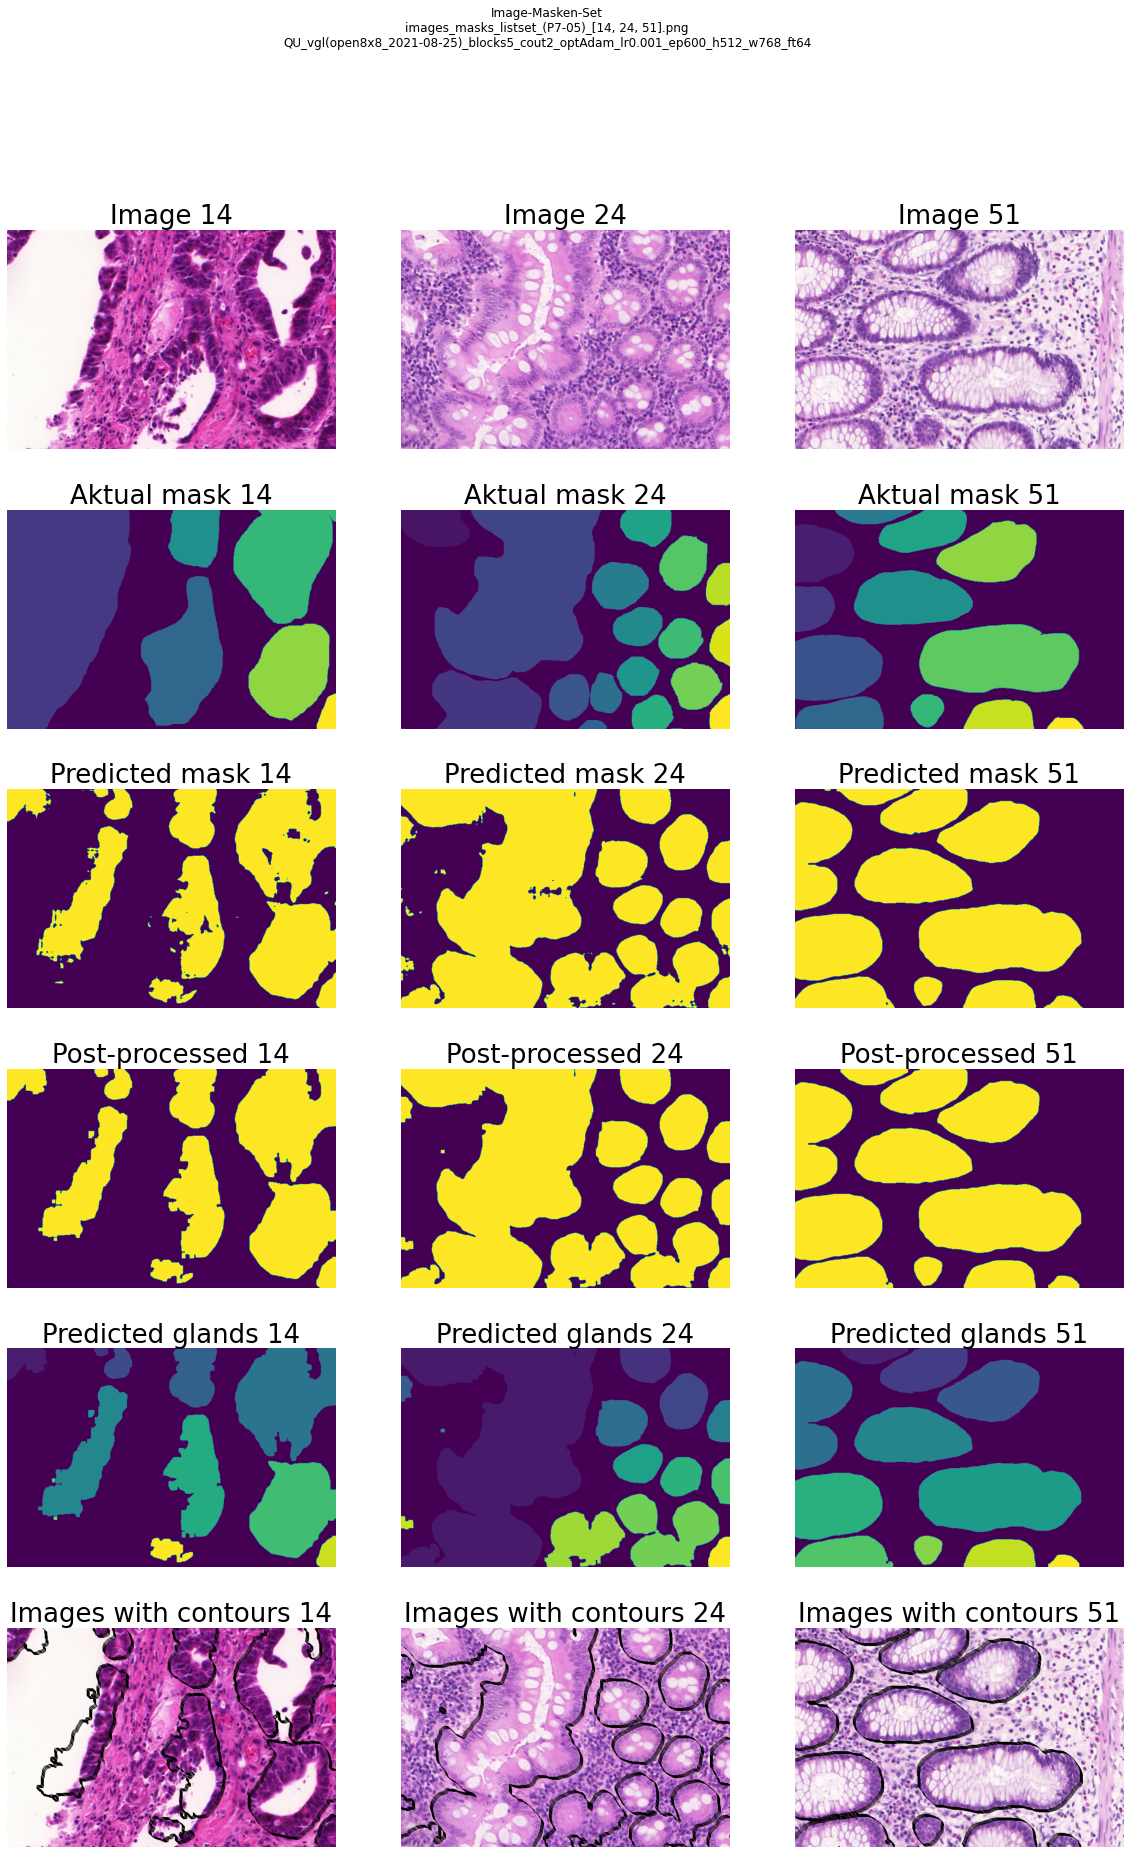

In [ ]:
idx_list=list([14,24,51])
path_set= path_experiment  / f'images_masks_listset_(P7-05)_{str(idx_list)}.png'
listset=list([input_images, actual_masks,         predict_masks,\
              predict_masks_morph,     predict_objects,  contourimage_list ] )
titles=list(['Image', 'Actual mask', 'Predicted mask',\
             'Post-processed',    'Predicted glands', 'Images with contours'])
show.list_set(idx_list, listset,titles, path=path_set)

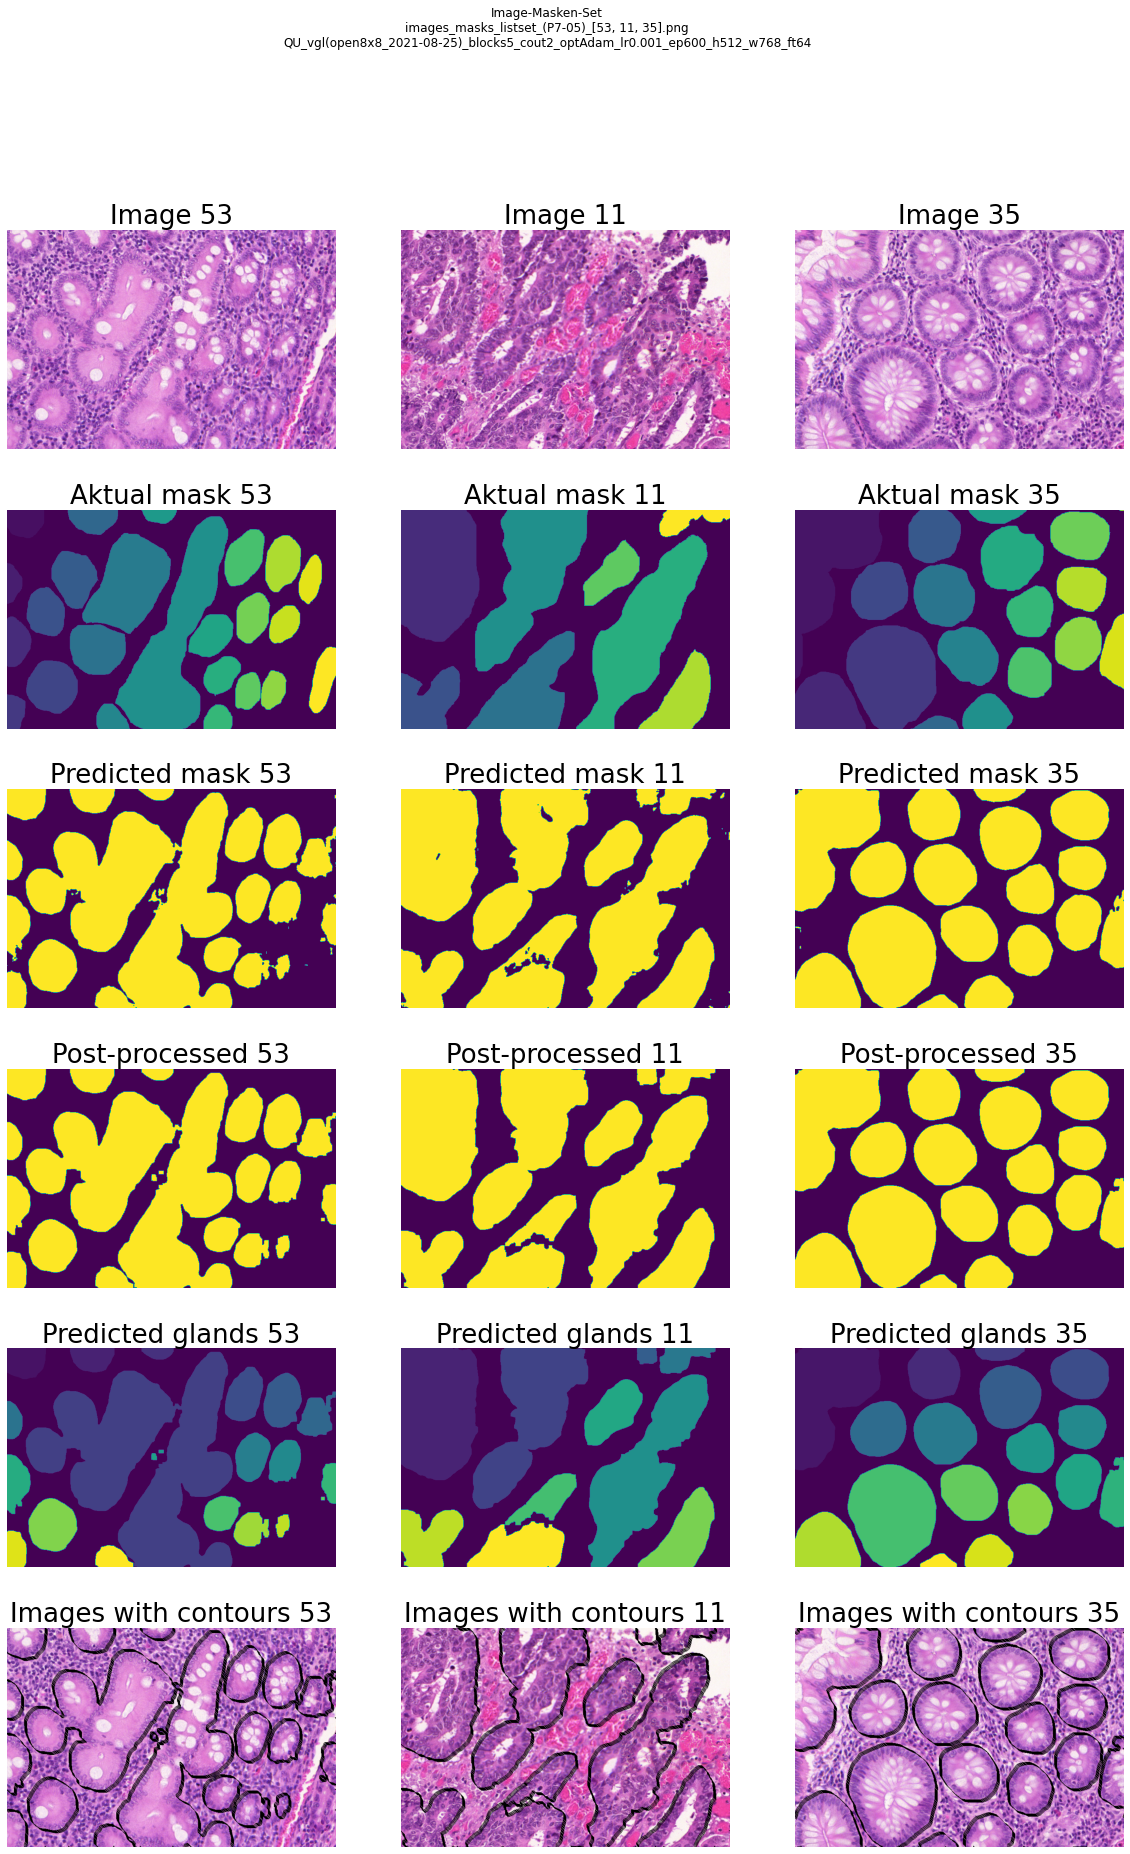

In [ ]:
idx_list=list([53,11,35])
path_set= path_experiment  / f'images_masks_listset_(P7-05)_{str(idx_list)}.png'
listset=list([input_images, actual_masks,         predict_masks,\
              predict_masks_morph,     predict_objects,  contourimage_list ] )
titles=list(['Image', 'Actual mask', 'Predicted mask',\
             'Post-processed',    'Predicted glands', 'Images with contours'])
show.list_set(idx_list, listset,titles, path=path_set)

In [ ]:
print('End of visualizing')

End of visualizing
